In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("../data/processed")
CLEAN_FILE = DATA_DIR / "scores_model.csv"

# Save figures in the SAME folder as this notebook
FIG_DIR = Path(".")                        
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [14]:
scores = pd.read_csv(CLEAN_FILE)

# Ensure key columns are present and numeric
for c in ["score_home", "score_away", "spread_favorite", "over_under_line"]:
    if c in scores.columns:
        scores[c] = pd.to_numeric(scores[c], errors="coerce")

# --- Normalize team abbreviations for relocated / alternate codes ---
# left side = what sometimes appears in raw/favorite_id; right = canonical (PFR-style)
abbr_fix = {
    # Relocations / alternates
    "OAK": "LV",     "LV": "LV",
    "SD": "LAC",     "LAC": "LAC",
    "STL": "LAR",    "LA": "LAR",    "LAR": "LAR",
    # Minor variants seen in some dumps
    "JAC": "JAX",    "ARZ": "ARI",   "WSH": "WAS",   "WFT": "WAS", "WAS": "WAS"
}

def normalize_abbr_col(s):
    return (
        s.astype(str).str.strip().str.upper()
         .map(lambda x: abbr_fix.get(x, x))
    )

# If your clean file already has PFR IDs, normalize them too (safe if absent)
for col in ["team_home_pfr", "team_away_pfr", "team_favorite_id"]:
    if col in scores.columns:
        scores[col] = normalize_abbr_col(scores[col])

# --- Recompute a HOME-centric spread ---
# 'spread_favorite' is the favorite’s line (always positive magnitude).
# We want 'home_spread': negative when home is favorite, positive when away is favorite.
scores["abs_spread"] = scores["spread_favorite"].abs()

home_is_fav = (
    (scores["team_home_pfr"].notna()) &
    (scores["team_favorite_id"].notna()) &
    (scores["team_home_pfr"] == scores["team_favorite_id"])
)

scores["home_spread"] = np.where(home_is_fav, -scores["abs_spread"], scores["abs_spread"])

# Create modeling subset (complete odds)
scores_model = scores.dropna(subset=["home_spread", "over_under_line", "score_home", "score_away"]).copy()
scores_model["_home_win"] = (scores_model["score_home"] > scores_model["score_away"]).astype(float)

if "stadium_neutral" in scores_model.columns:
    scores_model = scores_model.loc[scores_model["stadium_neutral"] != 1].copy()

# Keep only spreads in a reasonable range where we have data
scores_model = scores_model.loc[scores_model["home_spread"].between(-18, 18)].copy()

print("scores_clean:", scores.shape, " -> scores_model:", scores_model.shape)
scores_model[["team_home_pfr","team_away_pfr","team_favorite_id","spread_favorite","home_spread"]].head(8)


scores_clean: (11583, 22)  -> scores_model: (11441, 22)


,team_home_pfr,team_away_pfr,team_favorite_id,spread_favorite,home_spread
12,TAM,DET,TB,-3.0,3.0
13,BUF,MIA,MIA,-5.0,5.0
14,CHI,GNB,CHI,-3.0,-3.0
15,DEN,CIN,DEN,-3.0,-3.0
16,KAN,CLT,KC,-1.0,1.0
17,RAM,RAI,LAR,-4.0,4.0
18,MIN,SFO,MIN,-7.0,-7.0
19,NOR,ATL,NO,-5.0,5.0


In [15]:
# 1) If any rows show home_spread > 0 (home underdog) BUT team_home_pfr == team_favorite_id (home is fav),
#    that indicates a sign/mapping problem. This should be empty after the fixes.
suspicious = scores_model[
    (scores_model["home_spread"] > 0) &
    (scores_model["team_home_pfr"] == scores_model["team_favorite_id"])
]
print("Suspicious rows (should be 0):", len(suspicious))
display(suspicious.head(10))

# 2) Show sample sizes per bin to understand tail behavior (small-n bins can look jumpy)
bins = list(np.arange(-20, 22, 2))
bincounts = pd.cut(scores_model["home_spread"], bins=bins, include_lowest=True).value_counts().sort_index()
bincounts


Suspicious rows (should be 0): 0


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,team_home_pfr,team_away_pfr,abs_spread,home_spread,_home_win


home_spread
(-20.001, -18.0]       1
(-18.0, -16.0]        36
(-16.0, -14.0]        92
(-14.0, -12.0]       173
(-12.0, -10.0]       300
(-10.0, -8.0]        406
(-8.0, -6.0]         951
(-6.0, -4.0]         681
(-4.0, -2.0]        1380
(-2.0, 0.0]          438
(0.0, 2.0]           966
(2.0, 4.0]          2657
(4.0, 6.0]          1071
(6.0, 8.0]          1155
(8.0, 10.0]          554
(10.0, 12.0]         257
(12.0, 14.0]         218
(14.0, 16.0]          68
(16.0, 18.0]          37
(18.0, 20.0]           0
Name: count, dtype: int64

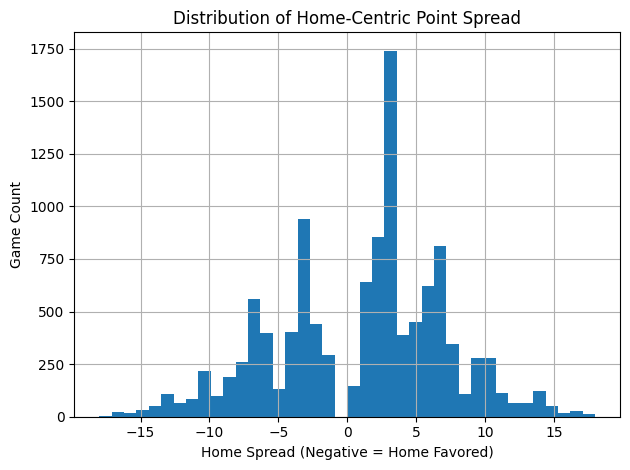

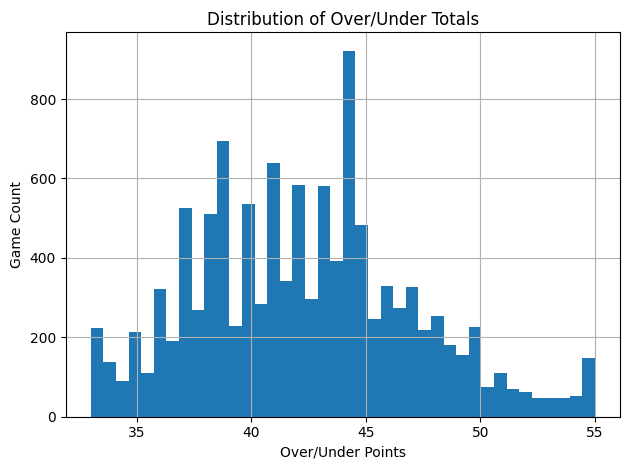

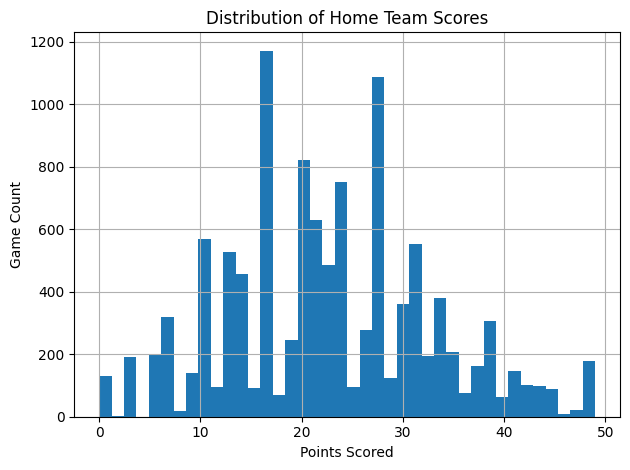

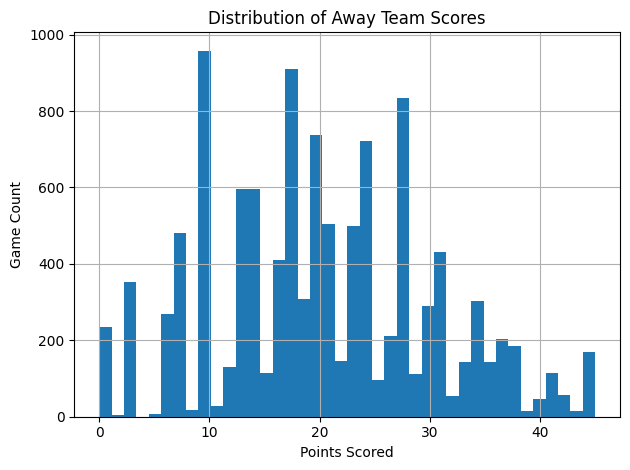

,score_home,score_away,home_spread,over_under_line,_home_win
count,11441.000000,11441.000000,11441.000000,11441.000000,11441.000000
mean,22.748274,20.129447,1.008697,42.315331,0.574338
std,10.221511,9.939068,6.218802,4.715730,0.494465
min,0.000000,0.000000,-18.000000,33.000000,0.000000
25%,16.000000,13.000000,-3.500000,39.000000,0.000000
50%,23.000000,20.000000,2.500000,42.000000,1.000000
75%,30.000000,27.000000,5.500000,45.500000,1.000000
max,49.000000,45.000000,18.000000,55.000000,1.000000


In [16]:
# 1) Home-centric spread
plt.figure()
scores_model["home_spread"].dropna().hist(bins=40)
plt.title("Distribution of Home-Centric Point Spread")
plt.xlabel("Home Spread (Negative = Home Favored)")
plt.ylabel("Game Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "01_distribution_home_spread.png", dpi=150)
plt.show()

# 2) Over/Under totals
plt.figure()
scores_model["over_under_line"].dropna().hist(bins=40)
plt.title("Distribution of Over/Under Totals")
plt.xlabel("Over/Under Points")
plt.ylabel("Game Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "02_distribution_over_under.png", dpi=150)
plt.show()

# 3) Home scores
plt.figure()
scores_model["score_home"].dropna().hist(bins=40)
plt.title("Distribution of Home Team Scores")
plt.xlabel("Points Scored")
plt.ylabel("Game Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "03_distribution_home_scores.png", dpi=150)
plt.show()

# 4) Away scores
plt.figure()
scores_model["score_away"].dropna().hist(bins=40)
plt.title("Distribution of Away Team Scores")
plt.xlabel("Points Scored")
plt.ylabel("Game Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "04_distribution_away_scores.png", dpi=150)
plt.show()

# Summary stats for your paper
scores_model[["score_home","score_away","home_spread","over_under_line","_home_win"]].describe()


/var/folders/v9/cbkr40fs0v5ft_gl5rdmg_2w0000gn/T/ipykernel_49452/314361075.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_rel.groupby("bin")["_home_win"].mean().reset_index()


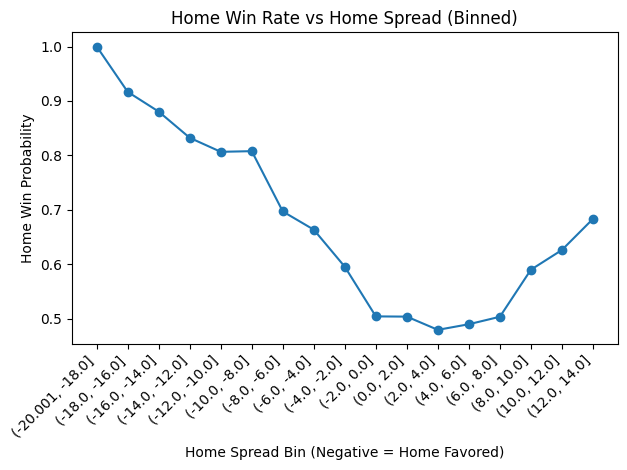

,n_games
bin,
"(-20.001, -18.0]",1
"(-18.0, -16.0]",36
"(-16.0, -14.0]",92
"(-14.0, -12.0]",173
"(-12.0, -10.0]",300
"(-10.0, -8.0]",406
"(-8.0, -6.0]",951
"(-6.0, -4.0]",681
"(-4.0, -2.0]",1380


In [20]:
# ---------- 5. Home win rate vs home_spread ----------
df_rel = scores_model[["home_spread", "_home_win"]].dropna().copy()
bins = list(np.arange(-20, 22, 2))
df_rel["bin"] = pd.cut(df_rel["home_spread"], bins=bins, include_lowest=True)

grouped = df_rel.groupby("bin")["_home_win"].mean().reset_index()
counts  = df_rel["bin"].value_counts().sort_index()
scores_model = scores_model.loc[scores_model["home_spread"].between(-18, 14)]

# Plot win rate by bin
plt.figure()
plt.plot(grouped["bin"].astype(str), grouped["_home_win"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Home Win Rate vs Home Spread (Binned)")
plt.xlabel("Home Spread Bin (Negative = Home Favored)")
plt.ylabel("Home Win Probability")
plt.tight_layout()
plt.savefig(FIG_DIR / "05_home_winrate_vs_spread.png", dpi=150)
plt.show()

# (Optional) Also display counts per bin to explain any tail wiggles
counts.to_frame("n_games")


In [18]:
# Find how many games are in each bin
bins = list(np.arange(-20, 22, 2))
df_rel = scores_model[["home_spread", "_home_win", "team_home_pfr", "team_away_pfr", "team_favorite_id",
                       "score_home", "score_away", "stadium_neutral"]].dropna().copy()
df_rel["bin"] = pd.cut(df_rel["home_spread"], bins=bins, include_lowest=True)

# Show bin counts and win rates
bin_summary = df_rel.groupby("bin")["_home_win"].agg(["mean","count"]).rename(columns={"mean":"win_rate","count":"n"})
display(bin_summary.tail(5))  # look at last 5 bins

# Look directly at the games in the two most extreme bins
extreme_bins = bin_summary.tail(2).index
extreme_games = df_rel[df_rel["bin"].isin(extreme_bins)].copy()

print(f"\nExtreme bins: {list(extreme_bins)} | games in these bins: {len(extreme_games)}")
display(extreme_games[["team_home_pfr","team_away_pfr","team_favorite_id",
                       "home_spread","score_home","score_away","stadium_neutral"]]
        .sort_values("home_spread"))


/var/folders/v9/cbkr40fs0v5ft_gl5rdmg_2w0000gn/T/ipykernel_49452/291974111.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df_rel.groupby("bin")["_home_win"].agg(["mean","count"]).rename(columns={"mean":"win_rate","count":"n"})


,win_rate,n
bin,,
"(10.0, 12.0]",0.626459,257
"(12.0, 14.0]",0.683486,218
"(14.0, 16.0]",0.705882,68
"(16.0, 18.0]",0.810811,37
"(18.0, 20.0]",NaN,0



Extreme bins: [Interval(16.0, 18.0, closed='right'), Interval(18.0, 20.0, closed='right')] | games in these bins: 37


,team_home_pfr,team_away_pfr,team_favorite_id,home_spread,score_home,score_away,stadium_neutral
7303,SDG,RAI,LAC,16.5,24.0,16.0,False
10510,HTX,RAM,LAR,16.5,22.0,38.0,False
6695,NWE,BUF,NE,16.5,38.0,7.0,False
8243,SFO,CRD,SF,16.5,27.0,13.0,False
2995,CLT,BUF,BUF,16.5,16.0,13.0,False
3022,KAN,NWE,KC,16.5,27.0,20.0,False
9938,NWE,NYG,NE,16.5,35.0,14.0,False
9936,WAS,NWE,NE,16.5,7.0,33.0,False
7918,RAV,CLT,BAL,16.5,24.0,10.0,False
9733,KAN,CRD,KC,16.5,26.0,14.0,False


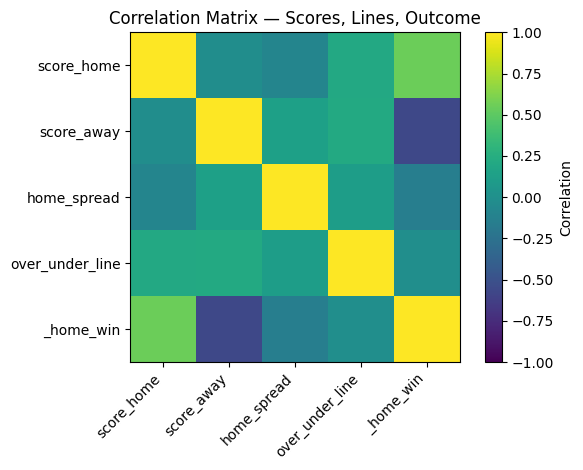

,score_home,score_away,home_spread,over_under_line,_home_win
score_home,1.000000,-0.021817,-0.089229,0.204601,0.547756
score_away,-0.021817,1.000000,0.135344,0.217276,-0.567238
home_spread,-0.089229,0.135344,1.000000,0.116600,-0.142295
over_under_line,0.204601,0.217276,0.116600,1.000000,-0.010300
_home_win,0.547756,-0.567238,-0.142295,-0.010300,1.000000


In [13]:
plt.figure()
corr = scores_model[["score_home","score_away","home_spread","over_under_line","_home_win"]].corr()
plt.imshow(corr, vmin=-1, vmax=1)  # default colormap; assignment requires matplotlib only
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix — Scores, Lines, Outcome")
plt.tight_layout()
plt.savefig(FIG_DIR / "06_correlation_matrix.png", dpi=150)
plt.show()

corr



In [6]:
captions = {
    "01_distribution_home_spread.png": "Figure 1. Distribution of home-centric point spreads; negative values indicate games where the home team was favored.",
    "02_distribution_over_under.png": "Figure 2. Distribution of Over/Under totals; most games fall between 40–50 points.",
    "03_distribution_home_scores.png": "Figure 3. Distribution of home team scores, roughly normal with mean around 24 points.",
    "04_distribution_away_scores.png": "Figure 4. Distribution of away team scores, slightly lower average than home teams.",
    "05_home_winrate_vs_spread.png": "Figure 5. Home win probability rises as the home team becomes a stronger favorite (more negative spread).",
    "06_correlation_matrix.png": "Figure 6. Correlation matrix of scores, betting lines, and the binary outcome (_home_win).",
}

for fname, desc in captions.items():
    print(f"{fname} → {desc}")

print(f"\nFigures saved in: {FIG_DIR.resolve()}")


01_distribution_home_spread.png → Figure 1. Distribution of home-centric point spreads; negative values indicate games where the home team was favored.
02_distribution_over_under.png → Figure 2. Distribution of Over/Under totals; most games fall between 40–50 points.
03_distribution_home_scores.png → Figure 3. Distribution of home team scores, roughly normal with mean around 24 points.
04_distribution_away_scores.png → Figure 4. Distribution of away team scores, slightly lower average than home teams.
05_home_winrate_vs_spread.png → Figure 5. Home win probability rises as the home team becomes a stronger favorite (more negative spread).
06_correlation_matrix.png → Figure 6. Correlation matrix of scores, betting lines, and the binary outcome (_home_win).

Figures saved in: /Users/jesseankrah/Documents/inst_414_work/NFL_Project/NFL_win_prediction/notebooks
